<a href="https://colab.research.google.com/github/Andrey22154/electricity-consumption-prediction/blob/main/electricity_consumption_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import plotly.graph_objects as go
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import cross_val_predict
#from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [30]:
df_1 = pd.read_excel('/content/mine_data.xlsx')

In [31]:
df_1['DateTime'] = df_1['/DateTime/Power/Haulage_speed/Traffic_flow'].str.split('/').str.get(1)
df_1['Power'] = df_1['/DateTime/Power/Haulage_speed/Traffic_flow'].str.split('/').str.get(2)
df_1['Haulage_speed'] = df_1['/DateTime/Power/Haulage_speed/Traffic_flow'].str.split('/').str.get(3)
df_1['Traffic_flow'] = df_1['/DateTime/Power/Haulage_speed/Traffic_flow'].str.split('/').str.get(4)
df_1.drop(['/DateTime/Power/Haulage_speed/Traffic_flow'], axis = 1, inplace = True)

In [32]:
df = df_1.dropna()
df['Haulage_speed'][0] = df['Haulage_speed'][1]

In [33]:
df['DateTime'] = df['DateTime'].apply(np.datetime64)
df['Power'] = df['Power'].apply(np.float64)
df['Traffic_flow'] = df['Traffic_flow'].apply(np.float64)
df['Haulage_speed'] = df['Haulage_speed'].apply(np.float64)

In [34]:
dd_1 = df.query('Haulage_speed == 0 & Power > 0')
dd_2 = df.query('Haulage_speed == 0 & Traffic_flow != 0')

df = df.drop(index = dd_2.index)
#df = df.drop(index = dd_1.index)

In [35]:
df = df[df['Power'] < 750]

In [36]:
df.index = df.DateTime
df = df.drop(['DateTime'], axis = 1)
Working_Shift_1 = df.between_time('09:00:00', '16:59:59') # Смена 1
Working_Shift_2 = df.between_time('17:00:00', '00:59:59') # Смена 2
Working_Shift_3 = df.between_time('01:00:00', '08:59:59') # Смена 3

In [37]:
work_time = []
for i in df.index:
  if (i == Working_Shift_1.index).any():
    work_time.append(1)
  if (i == Working_Shift_2.index).any():
    work_time.append(2)
  if (i == Working_Shift_3.index).any():
    work_time.append(3)

In [38]:
work_time = pd.DataFrame({'work_time':work_time})

In [39]:
df['DateTime'] = df.index
df.index = range(0, 579773)
df

,Power,Haulage_speed,Traffic_flow,DateTime
0,458.11,8.46,2423.0,2020-09-11 00:00:00
1,458.11,8.46,2440.0,2020-09-11 00:00:05
2,458.11,8.45,2453.0,2020-09-11 00:00:10
3,458.11,8.40,2463.0,2020-09-11 00:00:15
4,484.66,9.01,2483.0,2020-09-11 00:00:20
...,...,...,...,...
579768,0.00,0.00,0.0,2020-11-10 15:18:30
579769,0.00,0.00,0.0,2020-11-10 15:18:35
579770,0.00,0.00,0.0,2020-11-10 15:18:40
579771,0.00,0.00,0.0,2020-11-10 15:18:45


In [40]:
df_1 = pd.concat([df, work_time], axis = 1)

In [41]:
df_1['target'] = df_1.Power.shift(-17280)

In [42]:
df_1 = df_1.dropna()

In [43]:
df_1['Power_1'] = df_1.Power.shift(1)
df_1['Power_2'] = df_1.Power.shift(2)
df_1['Power_3'] = df_1.Power.shift(3)
df_1['Power_4'] = df_1.Power.shift(4)
df_1['Power_5'] = df_1.Power.shift(5)

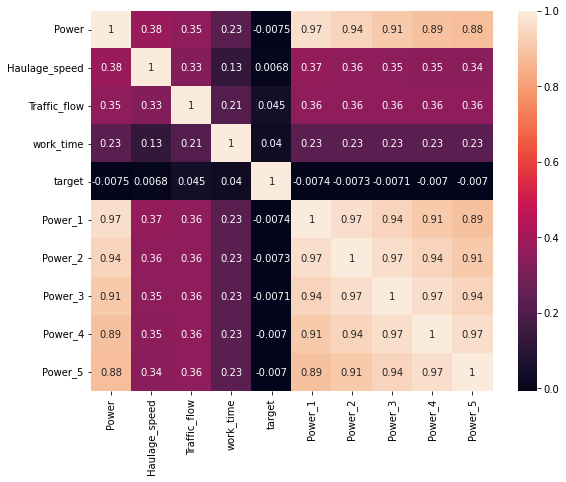

In [16]:
plt.figure(figsize = (9, 7))
corr = df_1.corr()
sns.heatmap(corr, annot = True)

In [44]:
df_1["second"] = df_1.DateTime.dt.second
df_1["minute"] = df_1.DateTime.dt.minute
df_1["hour"] = df_1.DateTime.dt.hour
df_1["weekday"] = df_1.DateTime.dt.weekday 
df_1["month"] = df_1.DateTime.dt.month
df_1["year"] = df_1.DateTime.dt.year

In [45]:
df_1 = df_1.dropna()

In [46]:
df_1.to_csv('DATAFRAME')

In [47]:
df_11 = df_1.drop(['DateTime'], axis = 1).copy()

In [25]:
X = df_1.drop(['target'], axis = 1)
y = df_1.target

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import cross_val_predict

In [26]:
kf =KFold(n_splits=5, shuffle=True, random_state=42)

cnt = 1
# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(X, y):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt += 1

Fold:1, Train set: 449990, Test set:112498
Fold:2, Train set: 449990, Test set:112498
Fold:3, Train set: 449990, Test set:112498
Fold:4, Train set: 449991, Test set:112497
Fold:5, Train set: 449991, Test set:112497


In [ ]:
from sklearn.model_selection import GridSearchCV
xgb_model = XGBRegressor()

parameters = {'booster':['gbtree'], 
              'colsample_bylevel': range(0, 1), 
              'colsample_bytree': range(0, 1), 
              'subsample':[0.8, 0.9],
              'gamma':[0.0, 0.1],
              'learning_fate':[0.1, 0.2, 0.3],
              'max_depth': range(7, 11),
              'n_estimators': range(4500, 5500, 2),
              'n_jobs':[-1],
              'seed':[555]}


clf = GridSearchCV(estimator=xgb_model,
                   param_grid=parameters,
                   scoring = 'r2',
                   cv = 5,
                   verbose=True)

clf.fit(X, y)
clf.best_estimator_

In [27]:
estimator = XGBRegressor(booster = 'gbtree', 
                         colsample_bylevel = 0.5, 
                         colsample_bytree = 0.7, 
                         subsample=0.9,
                         gamma = 0.1,
                         learning_fate = 0.1,
                         max_depth = 10,
                         n_estimators = 6000,
                         n_jobs = -1,
                         seed= 555
                         )
predictions = cross_val_predict(estimator, X, y, cv= kf, verbose = 10)            # Вывод результатов прогноза
predictions = pd.DataFrame({'predictions':predictions})

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[01:32:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 57.0min remaining:    0.0s


[02:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 115.5min remaining:    0.0s


[03:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 174.4min remaining:    0.0s


[04:26:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 233.4min remaining:    0.0s


[05:25:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 291.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 291.5min finished


In [49]:
predictions['target'] = df_1['target']
predictions['DateTime'] = df_1['DateTime']

In [76]:
df_1 = df_1.dropna()
predictions = predictions.dropna()

In [78]:
predictions.index = predictions['DateTime']
predictions = predictions.drop(['DateTime'], axis = 1)

In [79]:
predictions_10_min = predictions[:141]

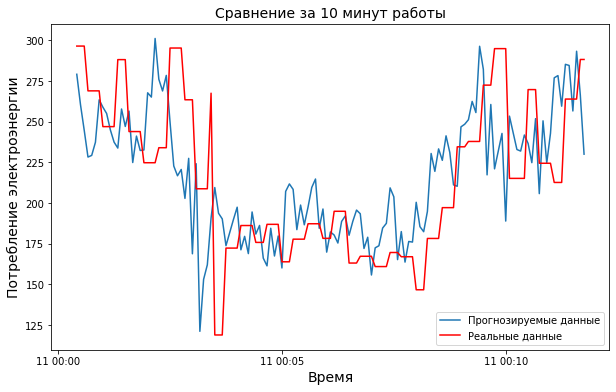

In [87]:
plt.figure(figsize = (10, 6))
sns.lineplot(data = df_1['predictions'], label = 'Прогнозируемые данные')
sns.lineplot(data = df_1['target'], color = 'red', label = 'Реальные данные')
plt.title('Сравнение за 10 минут работы', fontsize = 14)
plt.xlabel('Время', fontsize = 14)
plt.ylabel('Потребление электроэнергии', fontsize = 14)
plt.legend()
plt.show()

In [53]:
#plt.figure(figsize = (500, 15))
#sns.lineplot(data = df_1['pred'], label = 'Прогнозируемые данные')
#sns.lineplot(data = df_1['target'], color = 'red', label = 'Реальные данные')

In [96]:
r_2 = round(predictions.corr().target[0], 3)**2

In [99]:
print('Коэффицент детерминации модели = ', r_2)

Коэффицент детерминации модели =  0.734449
